In [511]:
import pandas as pd
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import Normalizer

In [1083]:
class myNN():
    def __init__(self, architecture, learning_rate):
        self.architecture = architecture
        self.learning_rate = learning_rate
        self.params = {}
        self.init_layers()
        
    def init_layers(self):
        #np.random.seed(99)
        for index, layer in enumerate(self.architecture):
            layer_index = index + 1
            layer_input_size = layer['input_dim']
            layer_output_size = layer['output_dim']
            self.params['W' + str(layer_index)] = np.random.randn(layer_output_size, layer_input_size)*0.1
            self.params['b' + str(layer_index)] = np.random.randn(layer_output_size, 1)*0.1
            #print(self.params['W'+str(layer_index)].shape)
            #print(self.params['W'+str(layer_index)])
            #print(self.params['b'+str(layer_index)])
            #print("*******")
            
    def sigmoid(self, Z):
        return 1/(1+np.exp(-Z))
    
    def relu(self, Z):
        return np.maximum(0,Z)
    
    def linear(self, Z):
        return Z
    
    def sigmoid_backward(self, dA, Z):
        sig = self.sigmoid(Z)
        return dA*sig*(1-sig)
    
    def relu_backward(self, dA, Z):
        dZ = np.array(dA, copy = True)
        dZ[Z<=0] = 0
        return dZ
    
    def linear_backward(self, dA, Z):
        return dA
    
    def single_layer_FP(self, A_prev, W_curr, b_curr, activation='relu'):
        #print(W_curr.shape)
        #print(A_prev.shape)
        Z_curr = np.dot(W_curr, A_prev) + b_curr
        #print(Z_curr.shape)
        #print("------")
        if activation == 'relu':
            activation_func = self.relu
        elif activation == 'sigmoid':
            activation_func = self.sigmoid
        elif activation == 'linear':
            activation_func = self.linear
        else:
            raise Exception('Non-supported activation function')
        return activation_func(Z_curr), Z_curr
    
    def forward_propagation(self, x):
        memory = {}
        A_curr = x
        for index, layer in enumerate(self.architecture):
            layer_index = index + 1
            A_prev = A_curr
            activation_func = layer['activation']
            W_curr = self.params['W'+str(layer_index)]
            b_curr = self.params['b'+str(layer_index)]
            A_curr, Z_curr = self.single_layer_FP(A_prev, W_curr, b_curr, activation_func)
            memory["A"+str(index)] = A_prev
            memory["Z"+str(layer_index)] = Z_curr
        return A_curr, memory
        
    def get_loss_value(self, y, y_predict):
        #delta = y - y_predict
        #loss = np.dot(delta, delta.T)
        #return np.squeeze(loss)
        return np.power(y_predict - y, 2).mean()
    
    def single_layer_BP(self, dA_curr, W_curr, b_curr, Z_curr, A_prev, activation='relu'):
        if activation == 'relu':
            activation_func = self.relu_backward
        elif activation == 'sigmoid':
            activation_func = self.sigmoid_backward
        elif activation == 'linear':
            activation_func = self.linear_backward
        else:
            raise Exception('Non-supported activation function')
        dZ_curr = activation_func(dA_curr, Z_curr)
        dW_curr = np.dot(dZ_curr, A_prev.T)
        db_curr = np.sum(dZ_curr, axis=1, keepdims=True)
        dA_prev = np.dot(W_curr.T, dZ_curr)
        return dA_prev, dW_curr, db_curr
    
    def back_propagation(self, y_predict, y, memory):
        grads_values = {}
        dA_prev = 2*(y_predict-y)
        #dA_prev = delta * np.ones(y.shape).reshape(1,-1)
        for layer_prev_index, layer in reversed(list(enumerate(self.architecture))):
            layer_cur_index = layer_prev_index+1
            activation_func = layer['activation']
            dA_curr = dA_prev
            A_prev = memory['A' + str(layer_prev_index)]
            Z_curr = memory['Z' + str(layer_cur_index)]
            W_curr = self.params['W'+str(layer_cur_index)]
            b_curr = self.params['b'+str(layer_cur_index)]
            dA_prev, dW_curr, db_curr = self.single_layer_BP(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation_func)
            grads_values['dW'+str(layer_cur_index)] = dW_curr
            grads_values['db'+str(layer_cur_index)] = db_curr
        return grads_values
    
    def update(self, grads_values):
        for index, layer in enumerate(self.architecture):
            layer_idx = index + 1
            self.params["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
            self.params["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]
    
    def train(self, x, y, epochs, batch_size=16):
        loss_history = []
        for i in range(epochs):
            x, y = shuffle(x, y)
            for i in range(0 ,x.shape[1], batch_size):
                x_min = x[i:i + batch_size]
                y_min = y[i:i + batch_size]
                y_predict, memory = self.forward_propagation(x_min.T)
                loss = self.get_loss_value(np.array([y_min]), y_predict)
                grads_values = self.back_propagation(y_predict, np.array([y_min]), memory)
                self.update(grads_values)
            #y_predict, memory = self.forward_propagation(x.T)
            #loss = self.get_loss_value(np.array([y]), y_predict)
            #grads_values = self.back_propagation(y_predict, np.array([y]), memory)
            #self.update(grads_values)
            y_predict, memory = self.forward_propagation(x.T)
            loss = self.get_loss_value(np.array([y]), y_predict)
            print("the loss %lf" % loss)
            loss_history.append(loss)
        return loss_history
    
    def show_parm(self):
        print(self.params)
    
    def predict(self, x):
        y_predict, memory = self.forward_propagation(x)
        return y_predict

In [1084]:
# https://www.itread01.com/feffx.html
# https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795
nn_architecture = [
    {"input_dim": 16, "output_dim": 32, "activation": "relu"},
    {"input_dim": 32, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 8, "activation": "relu"},
    #{"input_dim": 8, "output_dim": 4, "activation": "sigmoid"},
    {"input_dim": 8, "output_dim": 1, "activation": "linear"},
]
learning_rate = 0.000001

In [1085]:
# Orientation category : 2, 3, 4, 5
# Glazing Area Distribution : 0, 1, 2, 3, 4, 5
data = pd.read_csv('energy_efficiency_data.csv')
heating = data.pop('Heating Load')
cooling = data.pop('Cooling Load')

In [1086]:
# for one hot encoding
Orient = pd.get_dummies(data['Orientation'])
Glazing = pd.get_dummies(data['Glazing Area Distribution'])
data = pd.concat([data,pd.get_dummies(data['Orientation'], prefix='Orientation')],axis=1)
data = pd.concat([data,pd.get_dummies(data['Glazing Area Distribution'], prefix='Glazing Area Distribution')],axis=1)
data.drop(['Orientation'],axis=1, inplace=True)
data.drop(['Glazing Area Distribution'],axis=1, inplace=True)

In [1087]:
# split data
#data = Normalizer(norm='l1').fit_transform(data)
X_train, X_test, y_train, y_test = train_test_split(data.to_numpy(), heating.to_numpy(), test_size=0.25, random_state=42)

In [1088]:
model = myNN(nn_architecture, learning_rate)

In [1089]:
model.train(X_train, np.array(y_train), 1000, batch_size=8)
print("finish")

the loss 474.424211
the loss 415.449993
the loss 386.746336
the loss 335.618345
the loss 275.646438
the loss 228.100887
the loss 202.402139
the loss 168.268051
the loss 158.098065
the loss 133.540589
the loss 133.862781
the loss 132.198140
the loss 144.152653
the loss 130.061038
the loss 131.508297
the loss 131.050473
the loss 129.436746
the loss 129.492766
the loss 131.807464
the loss 128.117856
the loss 129.196380
the loss 134.353699
the loss 128.649630
the loss 127.920041
the loss 127.339795
the loss 127.009598
the loss 129.501425
the loss 127.368682
the loss 129.768808
the loss 126.483785
the loss 125.720966
the loss 126.859898
the loss 126.496111
the loss 125.222650
the loss 125.440744
the loss 124.989342
the loss 125.052294
the loss 126.259330
the loss 126.316204
the loss 124.504917
the loss 128.536883
the loss 129.451336
the loss 131.500053
the loss 123.234504
the loss 123.822431
the loss 123.239045
the loss 124.700362
the loss 121.753928
the loss 122.508377
the loss 135.348210


the loss 32.688290
the loss 32.847954
the loss 32.206158
the loss 33.621000
the loss 33.558748
the loss 35.211048
the loss 31.642045
the loss 41.962880
the loss 34.981439
the loss 31.244048
the loss 31.447220
the loss 32.086381
the loss 31.241722
the loss 44.125642
the loss 37.791938
the loss 31.284595
the loss 31.898879
the loss 32.184063
the loss 35.483742
the loss 31.751424
the loss 31.623666
the loss 35.991122
the loss 36.762612
the loss 36.171961
the loss 49.004146
the loss 31.402015
the loss 47.709096
the loss 34.462350
the loss 31.082512
the loss 33.152053
the loss 35.115583
the loss 34.586474
the loss 35.751831
the loss 31.573635
the loss 31.109605
the loss 34.824602
the loss 33.603373
the loss 31.464012
the loss 31.044602
the loss 31.477672
the loss 34.270896
the loss 31.107948
the loss 30.954149
the loss 34.521974
the loss 31.001109
the loss 34.830220
the loss 32.709133
the loss 31.094841
the loss 31.598176
the loss 31.154358
the loss 31.327862
the loss 32.356179
the loss 34.

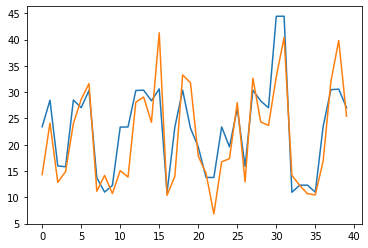

In [1090]:
y_predict = model.predict(X_train.T)
y_predict = np.squeeze(y_predict)
t = range(len(y_predict))
plt.plot(t[:40],y_predict[:40])
plt.plot(t[:40],y_train[:40])
plt.show()

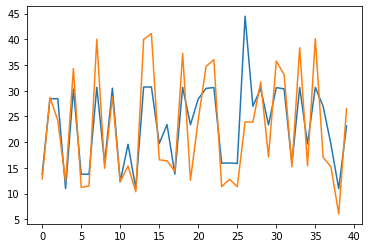

In [1091]:
y_predict = model.predict(X_test.T)
y_predict = np.squeeze(y_predict)
t = range(len(y_predict))
plt.plot(t[:40],y_predict[:40])
plt.plot(t[:40],y_test[:40])
plt.show()

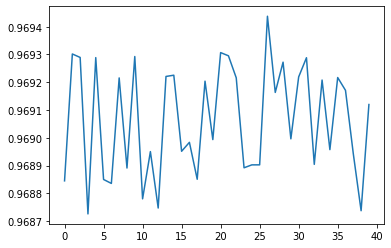

In [1071]:
plt.plot(t[:40],y_predict[:40])
plt.show()